In [1]:
#from mpdaf.obj import Sepctrum,Cube,Image
import matplotlib
from mpdaf.obj import mag2flux, flux2mag
from matplotlib import pyplot as plt
import numpy as np
from astropy.table import Table
matplotlib.rcParams.update({'font.size': 20})

In [2]:
from pyetc.wst import WST
from pyetc.etc import show_noise, get_seeing_fwhm

# Initialise ETC module

We start by creating the wst object with `wst = WST()`. To get more or less message, it is possible to use 
`wst = WST(log='DEBUG')` or `wst = WST(log='WARNING')` to have less. 

In [3]:
wst = WST(log='DEBUG')

The implemented instruments are the IFS (2 channels blue and red), the MOS-LR (2 channels blue and red) and the MOS-HR (4 channels U,B,V,I)

- The IFS channels are based on 4K CCD with a f/1 camera, leading to 0.25 arcsec spaxel. The LSF of 2.5 pixels, throughputs are inspired by MUSE and BlueMUSE. Note that the throughputs curves are for the telescope + instrument (excluding atmosphere).
- The MOS-LR channels are based on 6k detectors. Throughputs are inspired by 4MOST. Fiber have a 1 arcsec sky aperture. Sampling is 0.25 arcsec.
- The MOS-HR channels are based on a 9k detector. Fiber have a 0.94 arcsec sky aperture.
- In addition, paranal sky absorption and emssion are pre-computed for different conditions:
    - Moon : darksky (new moon), greysky (FLI = 0.5) and brightsky (full moon)
    - Airmass: 1, 1.2, 1.5, 2.0
    - Sky are computed with the ESO skycalc tool, using the proper spectral binning and LSF convolution for each channel
    
> the detail of the configuration is shown with `wst.info()`

In [4]:
wst.info()

[INFO] WST ETC version: 0.21
[INFO] Diameter: 11.25 m Area: 93.0 m2
[INFO] IFS type IFS Channel blue
[INFO] 	 Inspired from BlueMUSE throughput
[INFO] 	 version 0.1 10/02/2023
[INFO] 	 Spaxel size: 0.25 arcsec Image Quality tel+ins fwhm: 0.10 arcsec beta: 2.50 
[INFO] 	 Wavelength range [3700. 6100.] A step 0.64 A LSF 2.5 pix Npix 3751
[INFO] 	 Instrument transmission peak 0.38 at 5315 - min 0.28 at 3700
[INFO] 	 Detector RON 3.0 e- Dark 3.0 e-/h
[INFO] 	 Sky moon brightsky airmass 1.0 table ifs_blue_brightsky_1.0.fits
[INFO] 	 Sky moon brightsky airmass 1.2 table ifs_blue_brightsky_1.2.fits
[INFO] 	 Sky moon brightsky airmass 1.5 table ifs_blue_brightsky_1.5.fits
[INFO] 	 Sky moon brightsky airmass 2.0 table ifs_blue_brightsky_2.0.fits
[INFO] 	 Sky moon darksky airmass 1.0 table ifs_blue_darksky_1.0.fits
[INFO] 	 Sky moon darksky airmass 1.2 table ifs_blue_darksky_1.2.fits
[INFO] 	 Sky moon darksky airmass 1.5 table ifs_blue_darksky_1.5.fits
[INFO] 	 Sky moon darksky airmass 2.0 table

# Instruments and channels

The wst object has one telescope and two instruments: `wst.tel`, `wst.ifs` and `wst.moslr`. Each instrument has 2 channels: blue and red.
For example, to access the red channel of the ifs we have to use `wst.ifs['red']`. Each channel is a dictionary with all instrument properties. 

For example to list all elements of the MOS-LR blue channel, we will use `wst.moslr['blue'].keys()`.

In [5]:
wst.moslr['blue'].keys()

dict_keys(['desc', 'version', 'ref', 'type', 'iq_fwhm', 'iq_beta', 'spaxel_size', 'aperture', 'dlbda', 'lbda1', 'lbda2', 'lsfpix', 'ron', 'dcurrent', 'wave', 'sky', 'instrans', 'skys', 'chan', 'name'])

The dictionary keys are the following:

- desc: description of the channel
- name: channel name (eg ifs or moslr)
- chan: channel name (blue or red)
- type: instrument type (IFS or MOS)
- iq_fwhm: the FWHM of the image quality of telescope + instrument, excluding atmosphere
- iq_beta: the beta parameter of the MOFFAT image quality
- aperture: the fiber diameter aperture in arcsec (only for MOS)
- spaxel_size: the spaxel size in arcsec
- dlbda: the wavelength increment in A
- lbda1: starting wavelength in A
- lbda2: ending wavelength in A
- lsfpix: the LSF size in spectels (spectral pixels)
- ron: read-out noise in e- by pixel
- dcurrent: dark current in e-/hour by pixel
- wave: wavelength WaveCoord MPDAF object (see MPDAF spectrum documentation)
- instrans: total telescope + instrument transmission, excluding atmosphere (Spectrum MPDAF object)
- skys: the list of the name of all moon configuration e.g. `wst.ifs['blue']['skys'] = ['brightsky', 'darksky', 'greysky']`
- sky: a list of dictionnaries related to each sky configuration

One can view them the first one with `wst.ifs['blue']['sky'][0]`

In [6]:
wst.ifs['blue']['sky'][0]

{'moon': 'brightsky',
 'airmass': 1.0,
 'emi': <Spectrum(shape=(3751,), unit='', dtype='>f8')>,
 'abs': <Spectrum(shape=(3751,), unit='', dtype='>f8')>,
 'filename': '/Users/rolandbacon/Dropbox/Soft/python/pyetc/pyetc/data/WST/ifs_blue_brightsky_1.0.fits'}

# Spectral resolution

We now note **ins** a specific instrument channel, eg `ins = wst.ifs['red']` The function `ins.get_spectral_resolution()` return an array with the spectral resolution. The `ins['wave'].coord()`return the corresponding wavelength array.

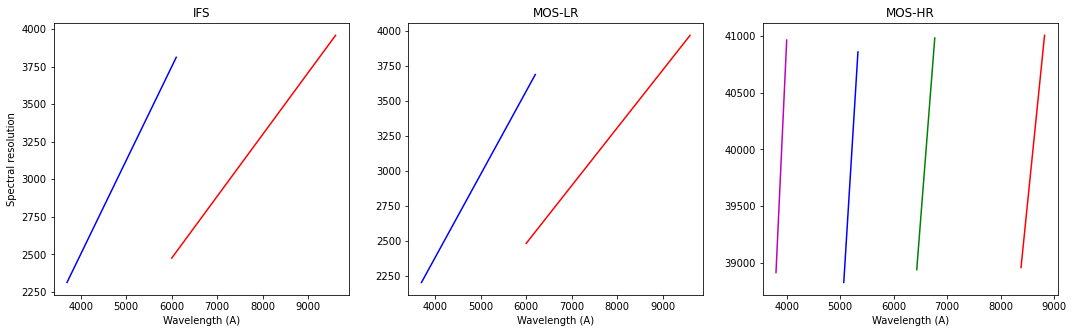

In [7]:
fig,ax = plt.subplots(1,3,figsize=(18,5))
ax[0].plot(wst.ifs['blue']['wave'].coord(), wst.get_spectral_resolution(wst.ifs['blue']), color='b')
ax[0].plot(wst.ifs['red']['wave'].coord(), wst.get_spectral_resolution(wst.ifs['red']), color='r')
ax[1].plot(wst.moslr['blue']['wave'].coord(), wst.get_spectral_resolution(wst.moslr['blue']), color='b')
ax[1].plot(wst.moslr['red']['wave'].coord(), wst.get_spectral_resolution(wst.moslr['red']), color='r')
ax[2].plot(wst.moshr['U']['wave'].coord(), wst.get_spectral_resolution(wst.moshr['U']), color='m')
ax[2].plot(wst.moshr['B']['wave'].coord(), wst.get_spectral_resolution(wst.moshr['B']), color='b')
ax[2].plot(wst.moshr['V']['wave'].coord(), wst.get_spectral_resolution(wst.moshr['V']), color='g')
ax[2].plot(wst.moshr['I']['wave'].coord(), wst.get_spectral_resolution(wst.moshr['I']), color='r')


ax[0].set_xlabel('Wavelength (A)')
ax[1].set_xlabel('Wavelength (A)')
ax[2].set_xlabel('Wavelength (A)')
ax[0].set_ylabel('Spectral resolution')
ax[0].set_title('IFS')
ax[1].set_title('MOS-LR');
ax[2].set_title('MOS-HR');

# Throughput

The `ins['instrans']` is a MPDAF spectrum with the total instrument plus telescope throughput.

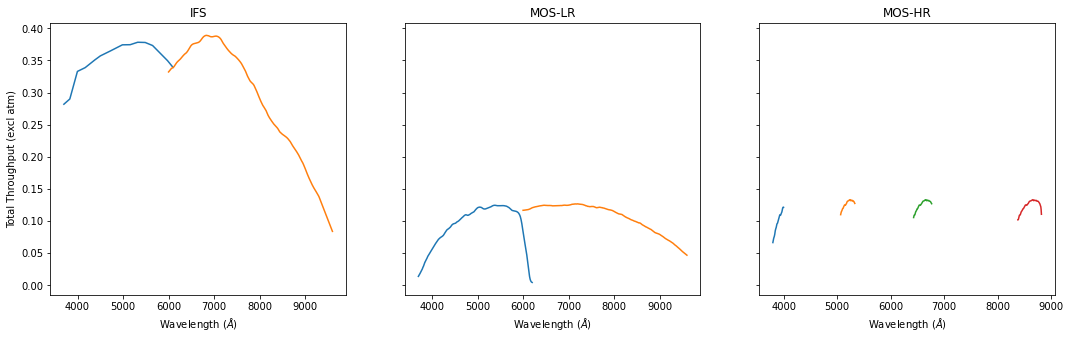

In [8]:
fig,ax = plt.subplots(1,3,figsize=(18,5), sharey=True)
ax[0].plot(wst.ifs['blue']['instrans'].wave.coord(), wst.ifs['blue']['instrans'].data)
ax[0].plot(wst.ifs['red']['instrans'].wave.coord(), wst.ifs['red']['instrans'].data)
ax[1].plot(wst.moslr['blue']['instrans'].wave.coord(), wst.moslr['blue']['instrans'].data)
ax[1].plot(wst.moslr['red']['instrans'].wave.coord(),wst.moslr['red']['instrans'].data)
for chan in wst.moshr['channels']:
    ax[2].plot(wst.moshr[chan]['instrans'].wave.coord(),wst.moshr[chan]['instrans'].data)
ax[0].set_xlabel(r'Wavelength ($\AA$)')
ax[1].set_xlabel(r'Wavelength ($\AA$)')
ax[2].set_xlabel(r'Wavelength ($\AA$)')
ax[0].set_ylabel('Total Throughput (excl atm)')
ax[0].set_title('IFS')
ax[1].set_title('MOS-LR');
ax[2].set_title('MOS-HR');

# Surface Brightness

We now derive S/N estimate for surface brightness sources. In this case the source is just defined by a spectrum. 
The function 
`spec = wst.get_spec(ins, dspec)`
is used to build the source spectrum. The dspec dictionnary has the spectrum parameters, there are currently three categories
of sources: flatcont, line and template. 

The **flatcont** type describe a flat continuum source:
`dict(type='flatcont', wave=[lbda1,lbda2])`
where wave is the wavelength range, in A. The result of the get_spec function is a MPDAF spectrum. The spectrum is normalized at 1.
See [here](https://mpdaf.readthedocs.io/en/latest/api/mpdaf.obj.Spectrum.html#mpdaf.obj.Spectrum) for the MPDAF Spectrum documentation.

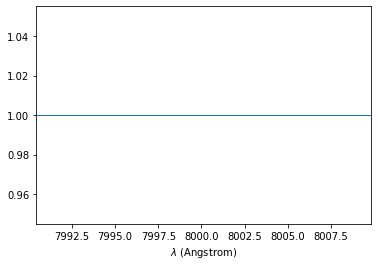

In [9]:
ifs = wst.ifs['red']
wave = 8000
dspec = dict(type='flatcont', wave=[wave-10,wave+10])
spec = wst.get_spec(ifs, dspec)
spec.plot()

The **line** type, describe an emission line. The emission line is modelled by a skewed gaussin function with
the following parameters: `dict(type='line', lbda=wave, sigma=4.0, skew=7.0)` where wave is the wavelength of the peak, sigma is the gaussian sigma and skew is the skew parameter. A Gaussian has skew=0.

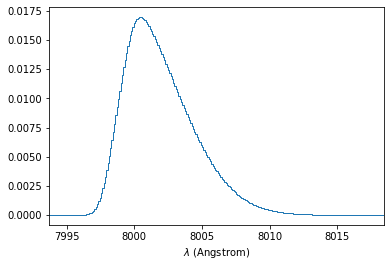

In [10]:
wave = 8000
dspec = dict(type='line', lbda=wave, sigma=4.0, skew=7.0)
spec = wst.get_spec(ifs, dspec)
spec.plot()

By default, the returned emission line spectrum is oversampled by a factor 10 with respect to the instrument
spctral sampling and convolved with the LSF. The rebinning and trunctation of the spectral is performed later. 
It is possible to change this parameters, but it is recommneded to keep the default LSF convolution and oversampling.

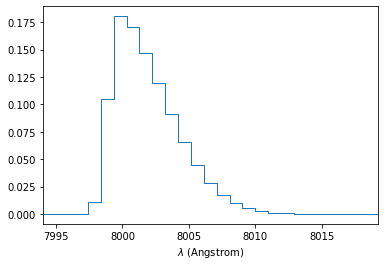

In [11]:
spec = wst.get_spec(ifs, dspec, oversamp=1, lsfconv=False)
spec.plot()

The **template** type describe one of the source of the **spextra** python library. Check the documentation
[here](https://spextra.readthedocs.io/en/latest/) for the complete list.
The parameters are the following:
- name, the name of the template
- wave_center, the central wavelength in A used to normalize the spectrum
- wave_wdth, the window in A used for the normailsation

Note that window does not need to be within the channel wavelngth interval.
The template spectrum is LSF convolved and resampled to the channel sampling.

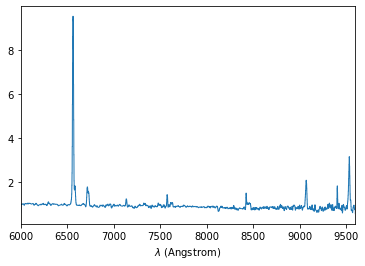

In [12]:
wave,dw = 6000,500
dspec = dict(type='template', name='kc96/starb1', 
             wave_center=wave, wave_width=dw)
spec = wst.get_spec(ifs, dspec)
spec.plot()

The next step is to define the observation parameters. They are written in a dictionnary which is add to the wst object by the `wst.set_obs(obs)` command.

The content of wst.obs is function of the source type. For surface brightness source it is
composed of:

- moon: the moon phase, it must be part of the pre-loaded configurations (currently **darksky, greysky or brightsky**).
- airmass: the observation airmass. Note that it must be part of the pre-loaded sky configuration, otherwise the program will raise an exception.
- ndit: the number of exposures
- dit: the integration time of one exposure in sec
- ima_type: sb, for surface brightness
- ima_area: the size of the area to be considered for S/N computation. It is needed only for IFS, for the MOS it is defined by the fiber aperture.
- spec_type: must be one of cont,line,template

in addition if spec_type is set to **line**, additional parameters are needed:
- spec_range_type: can be **fixed** or **adaptative**, used to define the spectral range to consider for the S/N computation.
- spec_range_hsize_spectels: if spec_range_type is fixed, it define the number of spectels to consider, the total size is 2 * spec_range_hsize_spectels + 1
- spec_range_kfwhm: if spec_range_type is adaptative, it compute the size of the window relative to the FWHM of the line.

The last parameter needed is the **flux** of the source in $erg.s^{-1}.cm^{-2}.arcsec^{-2}$ unit.
 

## Continuum source

In [13]:
obs = dict(
    moon='darksky',
    airmass = 1.0,
    ndit = 2, 
    dit = 1800, 
    spec_type = 'cont',
    ima_type = 'sb', 
    ima_area = 1.0
)
wst.set_obs(obs)

The estimate of S/N is then computed with the `wst.snr_from_source()` command. 

*Note that the ima parameter is set to None because we are in the surface brightness mode.*

In [14]:
flux = 5.e-19
res = wst.snr_from_source(ifs, flux, ima=None, spec=spec)

[DEBUG] Source type sb & cont Flux 5.00e-19 S/N 2.7 FracFlux 1.000 Nspaxels 16 Nspectels 1


The output of `snr_from_source` is the dictionary **res**. It contains the following elements:

- input: a dictionnary with some input data used in S/N computation
- cube: a dictionary that contains S/N measurements by voxels
- spec: a dictionnary that contains S/N summed over the spatial direction
- aper: a dictionnary with values summed over an aperture (only for line spectral type)

We detail the content of each dictionnary in the next paragraphs.

The **input** dictionary contains the following items:

- flux_source: the source flux in erg/s/cm2/voxel
- atm_abs: the atmospheric absorption
- atm_emi: the atmospheric emission in e-/s
- and all used **obs** parameters

In [15]:
res['input']

{'flux_source': <Spectrum(shape=(3712,), unit='', dtype='float64')>,
 'atm_abs': <Spectrum(shape=(3712,), unit='', dtype='>f8')>,
 'ins_trans': <Spectrum(shape=(3712,), unit='', dtype='float64')>,
 'atm_emi': <Spectrum(shape=(3712,), unit='', dtype='>f8')>,
 'dl': 0.97,
 'flux': 5e-19,
 'moon': 'darksky',
 'dit': 1800,
 'ndit': 2,
 'airmass': 1.0,
 'spec_type': 'cont',
 'ima_type': 'sb',
 'ima_area': 1.0}

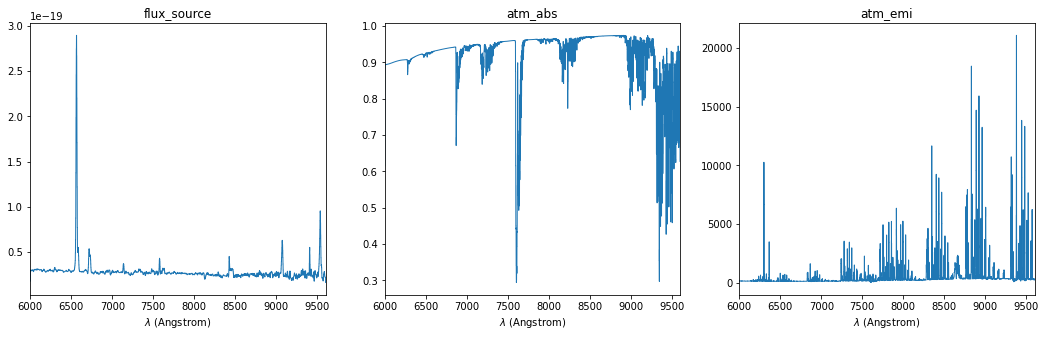

In [16]:
r = res['input']
fig,ax = plt.subplots(1,3,figsize=(18,5))
r['flux_source'].plot(ax=ax[0], title='flux_source')
r['atm_abs'].plot(ax=ax[1], title='atm_abs')
r['atm_emi'].plot(ax=ax[2], title='atm_emi')

The **cube** dictionary contains all quantities by voxels. Depending of the type of the source it can be datacubes, images or spectra. In the case of surface brightness source, it is restricted to spectra, because all spaxels are identical.

- snr: the snr spectrum *by voxel* which can be displayed with `snr.plot()`.
- noise: the noise dictionnary contains all sources of noise *by voxel*.
    - ron: the detector readout noise in e- (constant with wavelength)
    - dark: the detector dark current in e- (cosntant with wavelength)
    - sky: the sky noise spectrum in e-
    - source: the source noise spectrum in e-
    - tot: the total noise spectrum in e-
- nph_source: the number of source photo-electrons received by voxel
- nph_sky: the number of source photo-electrons received by voxel
    
The `show_noise(res['cube']['noise'], ax)` can be used to display the relative noise contrbution. 

*One can see in this example, that we are in photon noise regime, with 80% of the noise contribution due to the sky brightness.*

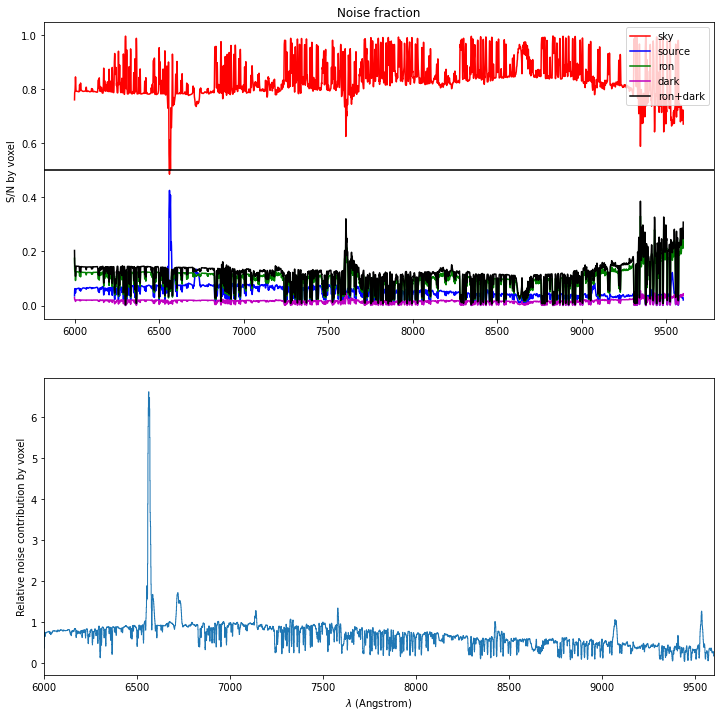

In [17]:
fig,ax = plt.subplots(2,1,figsize=(12,12))
res['cube']['snr'].plot(ax=ax[1])
ax[0].set_ylabel('S/N by voxel')
show_noise(res['cube']['noise'], ax[0], legend=True)
ax[1].set_ylabel('Relative noise contribution by voxel');

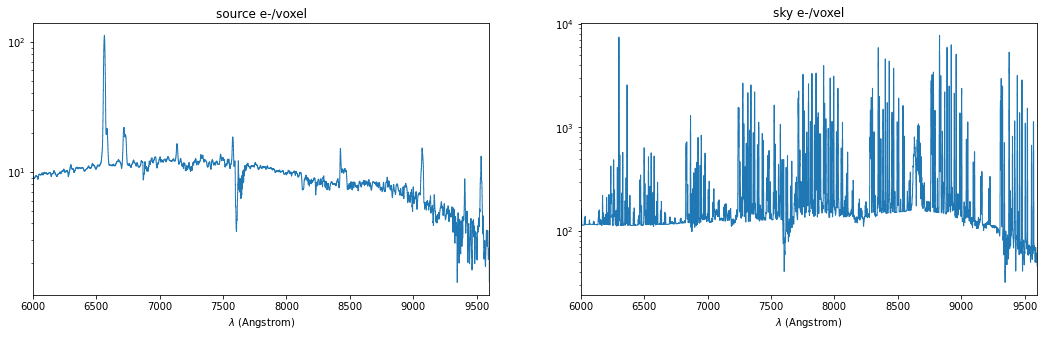

In [18]:
fig,ax = plt.subplots(1,2,figsize=(18,5))
res['cube']['nph_source'].plot(ax=ax[0], stretch='log', title='source e-/voxel')
res['cube']['nph_sky'].plot(ax=ax[1], stretch='log', title='sky e-/voxel')

The **spec** dictionary contains all spatially integrated quantities, in MPDAF spectrum format. Specifically it is
composed of:

- frac_flux: the total fraction of flux recovered (it is 1 in our case)
- frac_ima: thre fraction of flux recoovered in the spatial axis
- frac_spec: thre fraction of flux recoovered in the spectral axis
- nb_spaxels: the number of spaxels that have been summed
- nph_source: the number of source photo-electrons received by spectel
- nph_sky: the number of source photo-electrons received by spectel
- snr: the snr spectrum *by spectel* 
- snr_mean: the average value of the S/N by spectels
- snr_min: the minimum value of the S/N by spectels
- snr_max: the maximum value of the S/N by spectels
- noise: the noise dictionnary contains all sources of noise by spectel.
    - ron: the detector readout noise in e- (constant with wavelength)
    - dark: the detector dark current in e- (cosntant with wavelength)
    - sky: the sky noise spectrum in e-
    - source: the source noise spectrum in e-
    - tot: the total noise spectrum in e-

Text(0.9, 0.9, 'S/N mean 2.68 min 0.17 max 26.49')

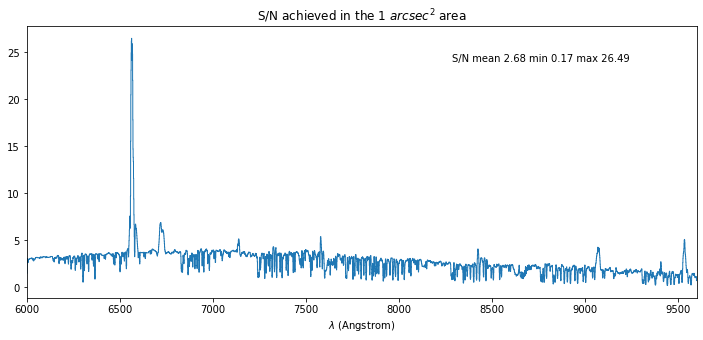

In [19]:
fig,ax = plt.subplots(1,1,figsize=(12,5))
sp = res['spec']
sp['snr'].plot(ax=ax, title=r'S/N achieved in the 1 $arcsec^2$ area')
ax.text(0.9, 0.9, f"S/N mean {sp['snr_mean']:.2f} min {sp['snr_min']:.2f} max {sp['snr_max']:.2f}",
       transform=ax.transAxes, ha='right', va='top')

## Emission line source

Computation for an emission line extended source is similar. This gives:

In [20]:
wave = 8000
dspec = dict(type='line', lbda=wave, sigma=4.0, skew=7.0)
spec = wst.get_spec(ifs, dspec)
obs = dict(
    moon='darksky',
    airmass = 1.2,
    ndit = 2, 
    dit = 1800, 
    spec_type = 'line',
    spec_range_type = 'fixed',
    spec_range_hsize_spectels = 7,
    ima_type = 'sb', 
    ima_area = 1.0,
)
wst.set_obs(obs)
flux = 1.e-18
res = wst.snr_from_source(ifs, flux, ima=None, spec=spec)

[DEBUG] Source type sb & line Flux 1.00e-18 S/N 0.8 FracFlux 0.962 Nspaxels 16 Nspectels 15


The **res** dictionary now contains an additional item: **aper**. This new directory contains measurements once integrated both spatially and spectrally. Specifically it contains:

- frac_flux: the total fraction of captured flux 
- frac_ima: the fraction of flux captured within the spatial aperture
- frac_spec: the fraction of flux captured along the spectral direction
- nb_spaxels: the number of summed spaxels 
- nb_spectels: the number of summed spectels
- nb_voxels: the total number of summed voxels
- nph_source: the number of source photo-electrons 
- nph_sky: the number of sky photo-electrons 
- snr: the snr spectrum 
- ron: the detector readout noise in e- 
- dark: the detector dark current in e- 
- sky_noise: the sky noise in e-
- source_noise: the source noise in e-
- tot_noise: the total noise in e-
- frac_detnoise: the ratio of the detector (ron+dark) variance to the total variance

The `wst.print_aper(res, title)` can be used to display the result

In [21]:
wst.print_aper(res, 'aperture values')

item,aperture values
bytes20,bytes20
snr,0.8249
size,1
area,1
frac_flux,0.962
frac_ima,1
frac_spec,0.962
nb_spaxels,16
nb_spectels,15
nb_voxels,240


The **cube** dictionary contains an additional element: **trunc_spec** which the spectrum after truncation by a window specified by the **spec_range_hsize_spectels** obs keyword. It is displayed here:

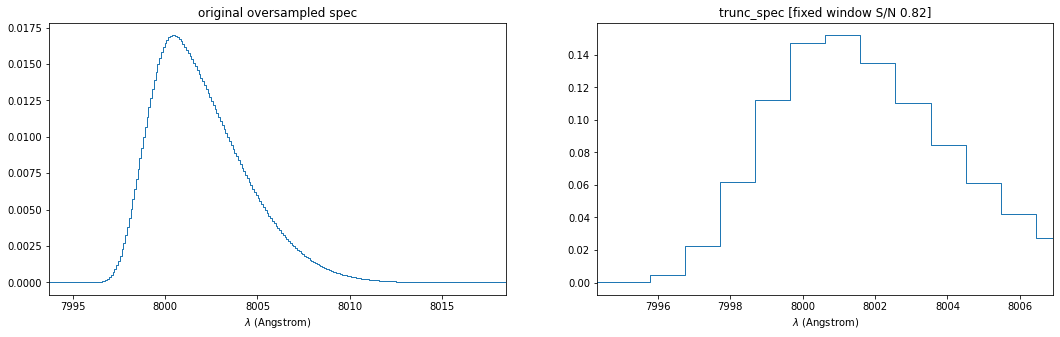

In [22]:
fig,ax = plt.subplots(1,2,figsize=(18,5))
spec.plot(ax=ax[0], title='original oversampled spec')
res['cube']['trunc_spec'].plot(ax=ax[1], title=f"trunc_spec [fixed window S/N {res['aper']['snr']:.2f}]")

Rather than using a window of fixed size, we can use an adaptative size which is function of the
fwhm of the line.

In [23]:
obs = dict(
    moon='darksky',
    airmass = 1.2,
    ndit = 2, 
    dit = 1800, 
    spec_type = 'line',
    spec_range_type = 'adaptative',
    spec_range_kfwhm = 2,
    ima_type = 'sb', 
    ima_area = 1.0,
)
wst.set_obs(obs)
res = wst.snr_from_source(ifs, flux, ima=None, spec=spec)

[DEBUG] Source type sb & line Flux 1.00e-18 S/N 1.6 FracFlux 0.974 Nspaxels 16 Nspectels 12


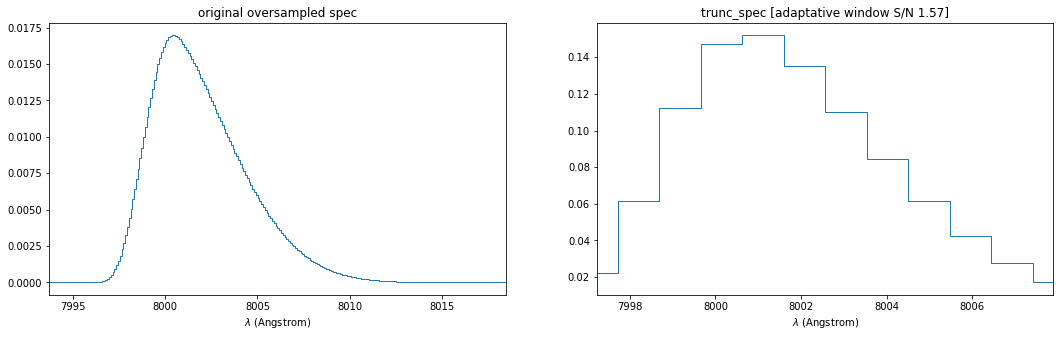

In [24]:
fig,ax = plt.subplots(1,2,figsize=(18,5))
spec.plot(ax=ax[0], title='original oversampled spec')
res['cube']['trunc_spec'].plot(ax=ax[1], title=f"trunc_spec [adaptative window S/N {res['aper']['snr']:.2f}]")

We see that the adptative window better follow the asymetric line shape and provide a S/N improved by a factor 2.

We can go one step further by using the `wst.optimum_spectral_range()` function to find the **spec_range_fkwhm** parameter whihc maximize the S/N. The optimum parameter is saved in the **obs** parameters, so we just need to rerun `snr_from_source` after.

In [25]:
kfwhm = wst.optimum_spectral_range(ifs, flux, None, spec)
res = wst.snr_from_source(ifs, flux, ima=None, spec=spec)

[DEBUG] Optimizing kwhm in [0.2766729197850376, 3.4362776637301673]
[DEBUG] Optimum spectral range nit=9 kfwhm=1.28 S/N=1.8 Size=6.8 Flux=1.00e-18 Frac=0.86
[DEBUG] Source type sb & line Flux 1.00e-18 S/N 1.8 FracFlux 0.864 Nspaxels 16 Nspectels 8


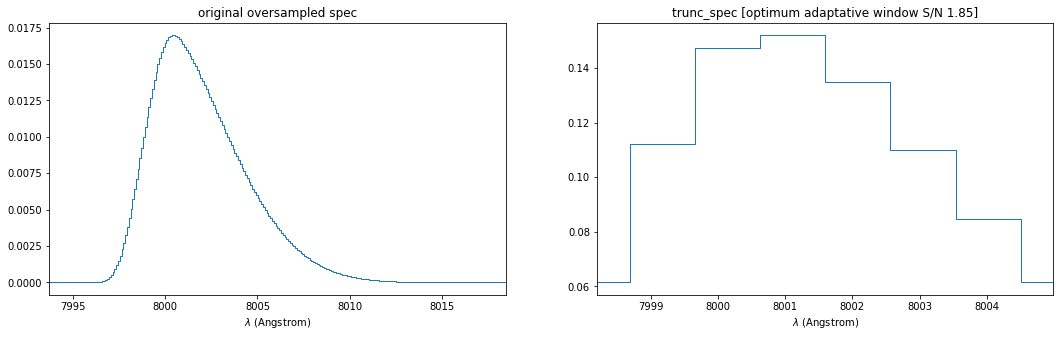

In [26]:
fig,ax = plt.subplots(1,2,figsize=(18,5))
spec.plot(ax=ax[0], title='original oversampled spec')
res['cube']['trunc_spec'].plot(ax=ax[1], title=f"trunc_spec [optimum adaptative window S/N {res['aper']['snr']:.2f}]")

## Retrieve flux for a given S/N

It is often useful to evaluate the flux limit, i.e. the flux which is needed to obtain a S/N of 3.
For this, we can use the `wst.flux_from_source` function.

In [27]:
snr = 3
res = wst.flux_from_source(ifs, snr, None, spec)

[DEBUG] Source type sb & line Flux 1.63e-18 S/N 3.0 FracFlux 0.864 Nspaxels 16 Nspectels 8
[DEBUG] SN 3.00 Flux 1.63e-18 Iter 6 Fcall 7 converged True


In the case of an emission line source, the estimated flux value is saved in `res['aper']['flux']`.

In [28]:
wst.print_aper(res, 'res')

item,res
bytes20,bytes20
snr,3
size,1
area,1
frac_flux,0.8643
frac_ima,1
frac_spec,0.8643
nb_spaxels,16
nb_spectels,8
nb_voxels,128


But in the case of a **cont** or **template** source, we have to specify a window range to compute an average target S/N. This is done with the **snrcomp** dictionary which specify a **method** and a wavelength range (**waves**) of the `wst.flux_from_source` function. Here is an example:

In [29]:
wave,dw = 6000,500
dspec = dict(type='template', name='kc96/starb1', 
             wave_center=wave, wave_width=dw)
spec = wst.get_spec(ifs, dspec)
obs = dict(
    moon = 'darksky',
    airmass = 1.0,
    ndit = 2, 
    dit = 1800, 
    spec_type = 'cont',
    ima_type = 'sb', 
    ima_area = 1.0
)
wst.set_obs(obs)
snr = 3
res = wst.flux_from_source(ifs, snr, None, spec, snrcomp=dict(method='mean', waves=[7000,8000]))

[DEBUG] Source type sb & cont Flux 5.68e-19 S/N 3.0 FracFlux 1.000 Nspaxels 16 Nspectels 1
[DEBUG] SN 3.33 Flux 5.68e-19 Iter 6 Fcall 7 converged True


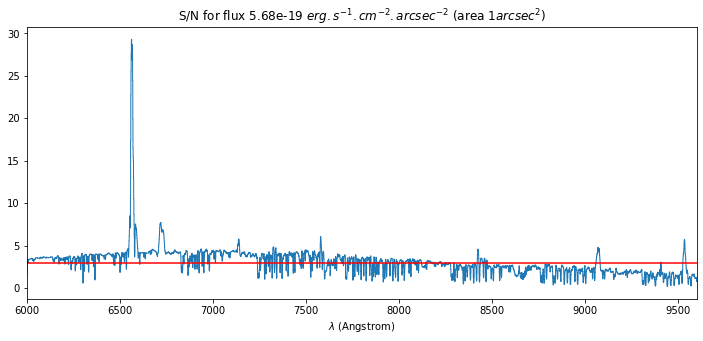

In [30]:
fig,ax = plt.subplots(1,1,figsize=(12,5))
res['spec']['snr'].plot(ax=ax)
ax.set_title(f"S/N for flux {res['spec']['flux']:.2e} "+r"$erg.s^{-1}.cm^{-2}.arcsec^{-2}$ (area $1 arcsec^2$)")
ax.axhline(3, color='r');

# Point Source

All objects with a size much smaller than the PSF are considered as point source. Their shape is given by the predicted atmospheric + telescope + instrument PSF.
The atmospheric seeing limited model is taken from the ESO VLT ETC, adapted to the larger size of the WST. The telescope plus instrument image quality is currently estimated to be 0.1 arcsec FWHM for the IFS and 0.3 arcsec FWHM for the MOS.

## Image Quality

Here is the total PSF at zenith for a seeing of 0.7 arcsec @ 500 nm.

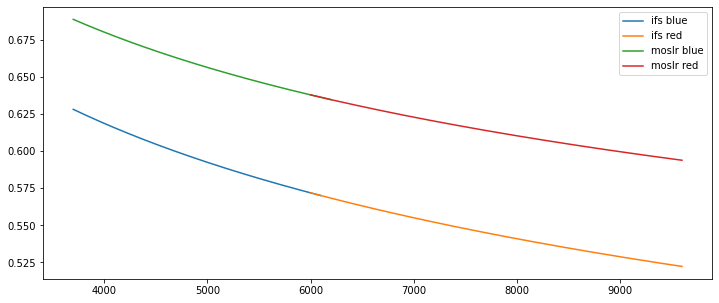

In [31]:
fig,ax = plt.subplots(1,1,figsize=(12,5))
seeing = 0.7
airmass = 1
for ins in [wst.ifs, wst.moslr]:
    for chan in ins['channels']:
        inst = ins[chan]
        wave = inst['wave'].coord()
        fwhm = get_seeing_fwhm(seeing, airmass, wave, wst.tel['diameter'], inst['iq_fwhm'])
        ax.plot(wave, fwhm, label=f"{inst['name']} {chan}")
ax.legend()

## Continuum source

To compute the S/N for a point source, we need to define the spectrum and the **seeing** and airmass of the observation. The **ima_type** is set to **ps**. Here is an example for a sun-like star with V AB mag of 23.


In [32]:
mos = wst.moslr['blue']
wave,dw  = 5500,500
dspec = dict(type='template', name='ref/sun', 
             wave_center=wave, wave_width=dw)
spec = wst.get_spec(mos, dspec)
mag = 23
flux = mag2flux(mag, wave)
obs = dict(
    moon = 'brightsky',
    seeing = 0.7,
    airmass = 1.0,
    ndit = 2, 
    dit = 1800, 
    spec_type = 'cont',
    ima_type = 'ps',
)
wst.set_obs(obs)

res = wst.snr_from_source(mos, flux, None, spec)

[DEBUG] Computing frac and nspaxels for 20 wavelengths (lbin 20)
[DEBUG] Performing interpolation
[DEBUG] At 3700.0 A  FWHM: 0.69 Flux fraction: 0.62 Aperture: 1.0 Nspaxels: 19
[DEBUG] At 6199.8 A  FWHM: 0.63 Flux fraction: 0.64 Aperture: 1.0 Nspaxels: 17
[DEBUG] Source type ps & cont Flux 2.27e-18 S/N 1.2 FracFlux 0.636 Nspaxels 18 Nspectels 1


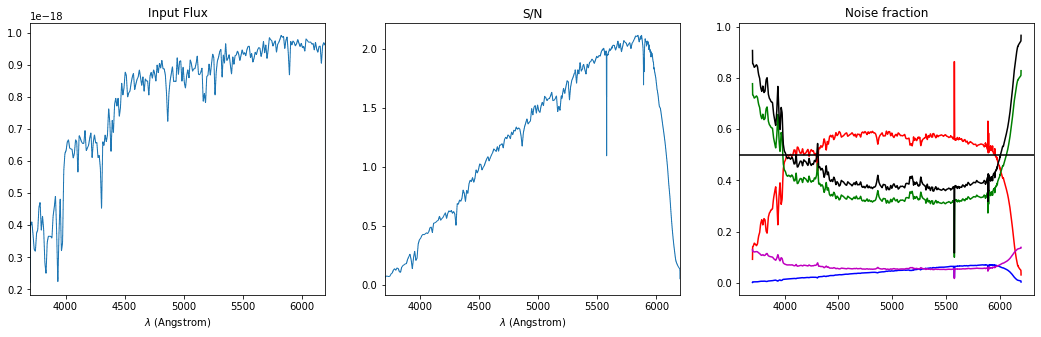

In [33]:
fig,ax = plt.subplots(1,3,figsize=(18,5))
res['input']['flux_source'].plot(ax=ax[0], title='Input Flux')
res['spec']['snr'].plot(ax=ax[1], title='S/N')
show_noise(res['spec']['noise'], ax=ax[2])

One can see that we are readout noise limited below 4000 A.

To perform the same computation with the IFS we need to define further parameters for the aperture. While it is fixed by the fiber aperture in the MOS design, for the IFS we have the choice between **circular_adaptative** or **square_fixed**. 
As indicated by its name **square_fixed** use a square aperture with a fixed size in spaxels defined by 2 x **ima_aperture_hsize_spaxels** + 1 spaxels.

The **circular_adaptative** method, is relative to the FWHM size of the image and use the **ima_kfwhm** parameter. As for the spectrum, it can be optimized using the
`optimum_circular_aperture` method. 

We show an example using the same source with the IFS blue channel. *Note that for the optimsation we have to define the **lrange** parameter in the routine*

In [34]:
ifs = wst.ifs['blue']
wave,dw  = 5500,500
dspec = dict(type='template', name='ref/sun', 
             wave_center=wave, wave_width=dw)
spec = wst.get_spec(ifs, dspec)
mag = 23
flux = mag2flux(mag, wave)

obs = dict(
    moon = 'brightsky',
    seeing = 0.7,
    airmass = 1.0,
    ndit = 2, 
    dit = 1800, 
    spec_type = 'cont',
    ima_type = 'ps',
    ima_aperture_type = 'circular_adaptative',
)
wst.set_obs(obs)
kfwhm = wst.optimum_circular_aperture(ifs, flux, None, spec, lrange=[4500,5500])
res = wst.snr_from_source(ifs, flux, None, spec)

[DEBUG] Optimum circular aperture nit=4 kfwhm=8.35 S/N=1.4 Aper=1.4 Flux=2.27e-18 Frac=0.96
[DEBUG] Computing optimum values for kfwhm
[DEBUG] Optimum circular aperture nit=6 kfwhm=7.47 S/N=1.1 Aper=1.4 Flux=2.27e-18 Frac=0.82
[DEBUG] Optimum circular aperture nit=9 kfwhm=8.81 S/N=1.3 Aper=1.5 Flux=2.27e-18 Frac=0.96
[DEBUG] Optimum values of kfwhm at wavelengths edges: [7.472135899375999, 8.809235395639938]
[DEBUG] Computing frac and nspaxels for 20 wavelengths (lbin 20)
[DEBUG] Performing interpolation
[DEBUG] At 3700.0 A  FWHM: 0.63 Flux fraction: 0.82 Aperture: 1.4 Nspaxels: 21
[DEBUG] At 6100.0 A  FWHM: 0.57 Flux fraction: 0.96 Aperture: 1.5 Nspaxels: 21
[DEBUG] Source type ps & cont Flux 2.27e-18 S/N 5.2 FracFlux 0.949 Nspaxels 21 Nspectels 1


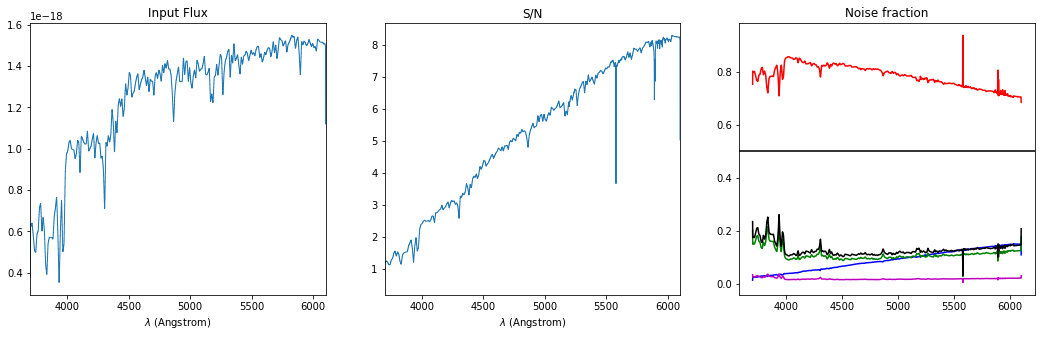

In [35]:
fig,ax = plt.subplots(1,3,figsize=(18,5))
res['input']['flux_source'].plot(ax=ax[0], title='Input Flux')
res['spec']['snr'].plot(ax=ax[1], title='S/N')
show_noise(res['spec']['noise'], ax=ax[2])

## Emission line source

We can repeat this computation with an emission line source. The process is similar to the surface brightness computation.


In [36]:
mos = wst.moslr['blue']
ifs = wst.ifs['blue']
wave = 4900
dspec = dict(type='line', lbda=wave, sigma=4.0, skew=7.0)
flux= 5.e-18
obs = dict(
    moon = 'darksky',
    seeing = 0.7,
    airmass = 1.0,
    ndit = 2, 
    dit = 1800, 
    spec_type = 'line',
    spec_range_type = 'adaptative',
    spec_range_kfwhm = 2,
    ima_type = 'ps', 
    ima_aperture_type = 'circular_adaptative',
    ima_kfwhm = 2
)
wst.set_obs(obs)
spec = wst.get_spec(ifs, dspec)
kfwhm_ima = wst.optimum_circular_aperture(ifs, flux, None, spec)
kfwhm_spec = wst.optimum_spectral_range(ifs, flux, None, spec)
res1 = wst.snr_from_source(ifs, flux, None, spec)
spec = wst.get_spec(mos, dspec)
res2 = wst.snr_from_source(mos, flux, None, spec)

[DEBUG] Optimum circular aperture nit=4 kfwhm=8.39 S/N=6.9 Aper=1.4 Flux=5.00e-18 Frac=0.96
[DEBUG] Optimizing kwhm in [0.21559252230162143, 3.919472055443478]
[DEBUG] Optimum spectral range nit=8 kfwhm=1.06 S/N=7.5 Size=5.1 Flux=5.00e-18 Frac=0.77
[DEBUG] Computing PSF at 4901.3 fwhm 0.59 beta 2.5
[DEBUG] Adaptive circular aperture diameter 1.43 frac_flux 0.96
[DEBUG] Source type resolved & line Flux 5.00e-18 S/N 7.5 FracFlux 0.737 Nspaxels 21 Nspectels 9
[DEBUG] Computing PSF at 4901.3 fwhm 0.66 beta 2.5
[DEBUG] Source type resolved & line Flux 5.00e-18 S/N 2.1 FracFlux 0.517 Nspaxels 19 Nspectels 15


The function `wst.print_aper()` can be used to display the tabulated differences between the MOS and the IFS

In [37]:
wst.print_aper([res1,res2],['ifs','mos'])

item,ifs,mos
bytes20,bytes20,bytes20
snr,7.546,2.121
size,1.427,1
area,1.599,0.7854
frac_flux,0.7366,0.5172
frac_ima,0.9556,0.6405
frac_spec,0.7708,0.8074
nb_spaxels,21,19
nb_spectels,9,15
nb_voxels,189,285


## Retrieve flux for a given S/N

It is also possible to retreive the flux to achieve a given S/N. Here is an example.

In [38]:
mos = wst.moslr['red']
ifs = wst.ifs['red']
moon = 'darksky'
wave = 8000
dspec = dict(type='line', lbda=wave, sigma=4.0, skew=7.0)
flux= 5.e-18
obs = dict(
    moon = 'darksky',
    seeing = 0.7,
    airmass = 1.0,
    ndit = 2, 
    dit = 1800, 
    spec_type = 'line',
    spec_range_type = 'adaptative',
    spec_range_kfwhm = 1.2,
    ima_type = 'ps', 
    ima_aperture_type = 'circular_adaptative',
    ima_kfwhm = 5
)
wst.set_obs(obs)
snr = 3
spec = wst.get_spec(ifs, dspec)
res1 = wst.flux_from_source(ifs, snr, None, spec)
spec = wst.get_spec(mos, dspec)
res2 = wst.flux_from_source(mos, snr, None, spec)

[DEBUG] Computing PSF at 8001.6 fwhm 0.54 beta 2.5
[DEBUG] Adaptive circular aperture diameter 0.83 frac_flux 0.67
[DEBUG] Source type resolved & line Flux 1.70e-18 S/N 3.0 FracFlux 0.578 Nspaxels 9 Nspectels 8
[DEBUG] SN 3.00 Flux 1.70e-18 Iter 6 Fcall 7 converged True
[DEBUG] Computing PSF at 8001.6 fwhm 0.61 beta 2.5
[DEBUG] Source type resolved & line Flux 3.64e-18 S/N 3.0 FracFlux 0.645 Nspaxels 17 Nspectels 12
[DEBUG] SN 3.00 Flux 3.64e-18 Iter 6 Fcall 7 converged True


In [39]:
wst.print_aper([res1,res2],['ifs','mos'])

item,ifs,mos
bytes20,bytes20,bytes20
snr,3,3
size,0.827,1
area,0.5371,0.7854
frac_flux,0.5783,0.6451
frac_ima,0.6691,0.7605
frac_spec,0.8643,0.8482
nb_spaxels,9,17
nb_spectels,8,12
nb_voxels,72,204


# Resolved source

Resolved sources are defined by an image and a spectrum. The image is computed with the `wst.get_image(ins, dima)` function, with **ins** the instrument channel and **dima** a dictionary describing the image model.
Currentkly there are two image models, the **moffat** model: It is describe by a **fwhm** in arcsec, a **beta** shape parameter, and optionnally an ellipticity **ell**, and the **sersic** model: it is described by an effective radius **reff** in arcsec, a sersic index **n**, and optionnally an ellipticity **ell**.

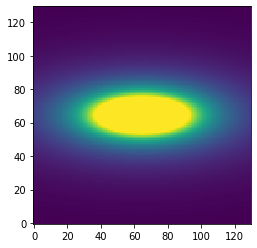

In [40]:
ifs = wst.ifs['red']
dima = dict(type='sersic', reff=1.0, n=2.0, ell=0.6)
ima = wst.get_ima(ifs, dima)
ima.plot(zscale=True)

## Continuum source

In MOS instrument, the spatial aperture is fixed by the fiber diameter in arcsec. 

For IFS there are two sort of apertures:

- **square_fixed**, the size of the aperture in spaxels is given by 2 * **ima_aperture_hsize_spaxels** + 1
- **circular_adaptative**, the aperture diameter is computed relativelt to the FWHM of the image and is given by **ima_kfwhm**

*Note that currently no PSF convolution is done on the image*

The final aperture used for the S/N computation can be found in the **res['cube']['trunc_ima']** image.
An example is given below:

In [41]:
ifs = wst.ifs['red']
wave = 7000
dspec = dict(type='flatcont', wave=[wave-10,wave+10])
spec = wst.get_spec(ifs, dspec)
dima = dict(type='moffat', fwhm=1.0, beta=2.5)
ima = wst.get_ima(ifs, dima)
mag = 23
flux = mag2flux(mag, wave)
obs = dict(
    moon = 'greysky',
    airmass = 1.0,
    ndit = 2, 
    dit = 1800, 
    spec_type = 'cont',
    ima_type = 'resolved',
    ima_aperture_type = 'circular_adaptative',
    ima_kfwhm = 5,
)

wst.set_obs(obs)
res1 = wst.snr_from_source(ifs, flux, ima, spec)
obs = dict(
    moon = 'greysky',
    airmass = 1.0,
    ndit = 2, 
    dit = 1800, 
    spec_type = 'cont',
    ima_type = 'resolved',
    ima_aperture_type = 'square_fixed',
    ima_aperture_hsize_spaxels = 2,
)
wst.set_obs(obs)
res2 = wst.snr_from_source(ifs, flux, ima, spec)

mos = wst.moslr['red']
spec = wst.get_spec(mos, dspec)
ima = wst.get_ima(mos, dima)
obs = dict(
    moon = 'greysky',
    airmass = 1.0,
    ndit = 2, 
    dit = 1800, 
    spec_type = 'cont',
    ima_type = 'resolved',
)
wst.set_obs(obs)
res3 = wst.snr_from_source(mos, flux, ima, spec)

[DEBUG] Adaptive circular aperture diameter 1.18 frac_flux 0.46
[DEBUG] Source type resolved & cont Flux 1.40e-18 S/N 3.1 FracFlux 0.461 Nspaxels 21 Nspectels 1
[DEBUG] Source type resolved & cont Flux 1.40e-18 S/N 3.4 FracFlux 0.565 Nspaxels 25 Nspectels 1
[DEBUG] Source type resolved & cont Flux 1.40e-18 S/N 1.0 FracFlux 0.371 Nspaxels 21 Nspectels 1


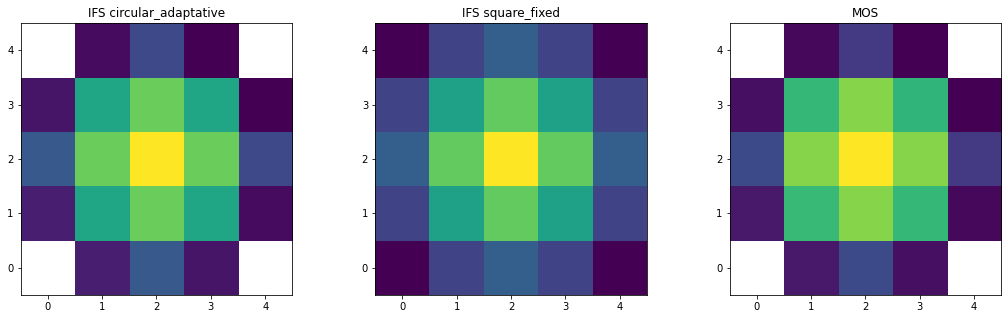

In [42]:
fig,ax = plt.subplots(1,3,figsize=(18,5))
res1['cube']['trunc_ima'].plot(ax=ax[0], title='IFS circular_adaptative')
res2['cube']['trunc_ima'].plot(ax=ax[1], title='IFS square_fixed')
res3['cube']['trunc_ima'].plot(ax=ax[2], title='MOS')

As for the spectrum adaptative spectral range, it is possible for the IFS to find the optimum **ima_kfwm** parameter to maximize the S/N. The function `wst.optimum_circular_aperture()` perform this task.
We illustrate this in the following.

In [43]:
ifs = wst.ifs['red']
wave = 7000
dspec = dict(type='flatcont', wave=[wave-10,wave+10])
spec = wst.get_spec(ifs, dspec)
dima = dict(type='moffat', fwhm=1.0, beta=2.5)
ima = wst.get_ima(ifs, dima)
mag = 23
flux = mag2flux(mag, wave)
obs = dict(
    moon = 'greysky',
    airmass = 1.0,
    ndit = 2, 
    dit = 1800, 
    spec_type = 'cont',
    ima_type = 'resolved',
    ima_aperture_type = 'circular_adaptative',
    ima_kfwhm = 5,
)
wst.set_obs(obs)
kfwhm = wst.optimum_circular_aperture(ifs, flux, ima, spec, lrange=[wave-5,wave+5])
res4 = wst.snr_from_source(ifs, flux, ima, spec)

[DEBUG] Optimum circular aperture nit=7 kfwhm=7.05 S/N=3.4 Aper=1.7 Flux=1.40e-18 Frac=0.66
[DEBUG] Adaptive circular aperture diameter 1.66 frac_flux 0.66
[DEBUG] Source type resolved & cont Flux 1.40e-18 S/N 3.3 FracFlux 0.659 Nspaxels 37 Nspectels 1


In [44]:
for res,name in zip([res3,res2,res1,res4],['MOS','IFS square fix','IFS circular adaptative','IFS optimum circular adaptative']):
    print(f"{name} S/N mean {res['spec']['snr_mean']:.2f} min {res['spec']['snr_min']:.2f} max {res['spec']['snr_max']:.2f}")

MOS S/N mean 0.99 min 0.89 max 1.02
IFS square fix S/N mean 3.44 min 3.03 max 3.58
IFS circular adaptative S/N mean 3.07 min 2.70 max 3.19
IFS optimum circular adaptative S/N mean 3.32 min 2.92 max 3.45


## Emission line source

The emission line source follow the same scheme. 

In [45]:
ifs = wst.ifs['blue']
wave = 4900
obs = dict(
    moon='darksky',
    airmass = 1.2,
    ndit = 2, 
    dit = 1800, 
    spec_type = 'line',
    spec_range_type = 'adaptative',
    spec_range_kfwhm = 2,
    ima_type = 'resolved',
    ima_aperture_type = 'circular_adaptative',
    ima_kfwhm = 5,
)
wst.set_obs(obs)
flux = 1.e-18
dspec = dict(type='line', lbda=wave, sigma=4.0, skew=7.0)
spec = wst.get_spec(ifs, dspec)
dima = dict(type='moffat', fwhm=1.0, beta=2.5)
ima = wst.get_ima(ifs, dima)
flux = 5.e-18
kfwhm = wst.optimum_circular_aperture(ifs, flux, ima, spec)
kfwhm = wst.optimum_spectral_range(ifs, flux, ima, spec)
res1 = wst.snr_from_source(ifs, flux, ima, spec)
mos = wst.moslr['blue']
spec = wst.get_spec(mos, dspec)
ima = wst.get_ima(mos, dima)
kfwhm = wst.optimum_spectral_range(mos, flux, ima, spec)
res2 = wst.snr_from_source(mos, flux, ima, spec)


[DEBUG] Optimum circular aperture nit=7 kfwhm=7.05 S/N=3.4 Aper=1.7 Flux=5.00e-18 Frac=0.66
[DEBUG] Optimizing kwhm in [0.21559252230162143, 3.919472055443478]
[DEBUG] Optimum spectral range nit=10 kfwhm=0.98 S/N=3.7 Size=5.1 Flux=5.00e-18 Frac=0.77
[DEBUG] Adaptive circular aperture diameter 1.66 frac_flux 0.66
[DEBUG] Source type resolved & line Flux 5.00e-18 S/N 3.7 FracFlux 0.508 Nspaxels 37 Nspectels 9
[DEBUG] Optimizing kwhm in [0.13307262126845637, 3.808538420703222]
[DEBUG] Optimum spectral range nit=10 kfwhm=1.17 S/N=1.1 Size=6.1 Flux=5.00e-18 Frac=0.84
[DEBUG] Source type resolved & line Flux 5.00e-18 S/N 1.1 FracFlux 0.310 Nspaxels 21 Nspectels 16


In [46]:
wst.print_aper([res1,res2],['IFS','MOS'])

item,IFS,MOS
bytes20,bytes20,bytes20
snr,3.748,1.124
size,1.665,1
area,2.177,0.7854
frac_flux,0.5081,0.3103
frac_ima,0.6592,0.371
frac_spec,0.7708,0.8365
nb_spaxels,37,21
nb_spectels,9,16
nb_voxels,333,336
